Nama: Yusuf Arico Pratama<br>
VIX: Data Science

# Latar Belakang Tugas

Sebagai tugas akhir dari masa kontrakmu sebagai intern Data Scientist di ID/X Partners, kali ini kamu akan dilibatkan dalam projek dari sebuah lending company. Kamu akan berkolaborasi dengan berbagai departemen lain dalam projek ini untuk menyediakan solusi teknologi bagi company tersebut. ***Kamu diminta untuk membangun model yang dapat memprediksi credit risk menggunakan dataset yang disediakan oleh company yang terdiri dari data pinjaman yang diterima dan yang ditolak.*** Selain itu kamu juga perlu mempersiapkan media visual untuk mempresentasikan solusi ke klien. Pastikan media visual yang kamu buat jelas, mudah dibaca, dan komunikatif. Pengerjaan end-to-end solution ini dapat dilakukan di Programming Language pilihanmu dengan tetap mengacu kepada framework/methodology Data Science.

# Tujuan

***Credit risk prediction*** adalah cara yang efektif untuk mengevaluasi apakah calon peminjam akan melunasi pinjaman, khususnya dalam pinjaman peer-to-peer di mana masalah ketidakseimbangan kelas yang lazim terjadi.

# Import library

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

In [2]:
# Read and load data into dataframe
loan_data = pd.read_csv('loan_data_2007_2014.csv')
loan_data.head()

C:\Users\yusuf arico\AppData\Local\Temp\ipykernel_8964\2728420121.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv('loan_data_2007_2014.csv')


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check the data size
loan_data.shape

(466285, 75)

## Define Target Variable / Labeling

In [4]:
# Cek kolom 'loan_status'. loan_status akan menjadi data untuk target prediksi
loan_data.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [5]:
# Mendapatkan proporsi dari nilai observasi dari nilai unik setiap variabel
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

Karena kita ingin memprediksi apakah suatu pinjaman bersifat beresiko atau tidak, maka kita perlu mengetahui histori akhir dari setiap jenis pinjaman apakah pinjaman tersebut gagal bayar / ditagih, atau lunas. Selanjutnya, kita akan mengklasifikasikan pinjaman tersebut sebagai ***good loans*** (tidak berisiko) dan ***bad loans*** (berisiko).

- good loans = **['Current', 'Fully Paid', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']**
- bad loans = **['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off']**

In [6]:
# definikan nilai
good_loans = ['Current', 'Fully Paid', 'In Grace Period', 
              'Does not meet the credit policy. Status:Fully Paid']

# membuat kolom baru untuk proses klasifikasi
loan_data['good_bad_loan'] = np.where(loan_data['loan_status'].isin(good_loans), 1, 0)

<AxesSubplot:title={'center':'Good (1) vs Bad (0) Loans Balance'}>

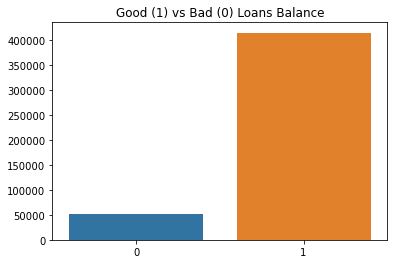

In [7]:
# check balance
plt.title('Good (1) vs Bad (0) Loans Balance')
sns.barplot(x=loan_data.good_bad_loan.value_counts().index,y=loan_data.good_bad_loan.value_counts().values)

## Data Pre-processing, Cleaning, and Feature Engineering

**Drop columns:**
- Drop kolom 'Unnamed: 0' yang merupakan salinan dari nilai index.
- Drop the columns having > 50% missing values. (columns with 0 unique value are also columns that have 100% missing value)
- Drop kolom yang mempunyai > 50% *missing values*. (kolom bernilai 0 juga temasuk kolom yang mempunyai *missing value*)
- Drop kolom 'application_type' dan 'policy_code' (karena hanya mempunyai 1 *unique value*).
- Drop *identifier columns:* id, member_id, title, emp_title, url, zip_code, desc, policy_code (Tidak bisa digunakan untuk membuat model).
- Drop sub_grade, karena memiliki informasi yang sama dengan kolom grade columns.

In [8]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 76 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [9]:
# get a list of columns that have more than 50% null values
na_values = loan_data.isnull().mean()
na_values[na_values>0.5]

desc                           0.729815
mths_since_last_delinq         0.536906
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
annual_inc_joint               1.000000
dti_joint                      1.000000
verification_status_joint      1.000000
open_acc_6m                    1.000000
open_il_6m                     1.000000
open_il_12m                    1.000000
open_il_24m                    1.000000
mths_since_rcnt_il             1.000000
total_bal_il                   1.000000
il_util                        1.000000
open_rv_12m                    1.000000
open_rv_24m                    1.000000
max_bal_bc                     1.000000
all_util                       1.000000
inq_fi                         1.000000
total_cu_tl                    1.000000
inq_last_12m                   1.000000
dtype: float64

In [10]:
# Filtering data with less than 2 unique values
loan_data.nunique()[loan_data.nunique() < 2].sort_values()

mths_since_rcnt_il           0
inq_fi                       0
all_util                     0
max_bal_bc                   0
open_rv_24m                  0
open_rv_12m                  0
il_util                      0
total_bal_il                 0
total_cu_tl                  0
inq_last_12m                 0
open_il_12m                  0
open_il_6m                   0
open_acc_6m                  0
verification_status_joint    0
dti_joint                    0
annual_inc_joint             0
open_il_24m                  0
application_type             1
policy_code                  1
dtype: int64

In [11]:
# Drop the irrelevant columns
loan_data.drop(['Unnamed: 0', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 
                'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 
                'open_il_12m', 'open_il_24m','mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 
                'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'policy_code', 
                'application_type','id', 'member_id', 'sub_grade', 'emp_title', 'url', 'title', 
                'zip_code'], axis=1, inplace = True)

### Data Understanding and Data Leakage

Pemahaman data/kolom itu penting. Saya ingin memprediksi apakah suatu pinjaman berisiko atau tidak, sebelum saya berinvestasi dalam pinjaman tersebut, bukan setelahnya. Masalah dengan data yang ada di kolom yang terkait dengan status pinjaman saat ini. Saya hanya bisa mendapatkan data dari kolom tersebut setelah pinjaman dikeluarkan, dengan kata lain, setelah saya berinvestasi dalam pinjaman.

- Kolom terkait status pinjaman saat ini (setelah diterbitkan): **[['issue_d', 'loan_status', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'pemulihan', 'collection_recovery_fee', 'last_pymnt_d ', 'last_pymnt_amnt', 'next_pymnt_d']]**

Misal, **'out_prncp'** (outstanding principal (Sisa sisa pokok pinjaman untuk total dana yang didanai)), bila out_prncp adalah 0, maka berarti pinjaman sudah lunas, mudah diprediksi berdasarkan variabel yang satu ini saja, dan akan menjadi sangat akurat. <br>
Contoh lain adalah dengan 'pemulihan', pemulihan hanya terjadi setelah peminjam tidak mampu membayar pinjaman dan lembaga pemberi pinjaman memulai proses pemulihan pinjaman. Tentu kita tahu bahwa pinjaman itu buruk dan berisiko, hanya dari info ini saja. Variabel-variabel tersebut dapat diprediksi dengan sangat akurat karena sudah terjadi.

Dalam ilmu data, variabel semacam ini disebut Kebocoran Data. Kebocoran Data ***(Data Leakage)*** adalah pembuatan informasi tambahan yang tidak terduga dalam data pelatihan, yang memungkinkan model atau algoritme pembelajaran mesin membuat prediksi yang tidak realistis. Ini adalah data yang tidak akan kami dapatkan saat kami menggunakan model dalam penerapan. Kami tidak akan tahu apakah akan ada biaya pemulihan, atau apakah pokok pinjaman akan menjadi 0 atau tidak sebelum pinjaman selesai. Kami tidak akan mendapatkan data tersebut sebelum kami berinvestasi dalam pinjaman.

Jadi, kolom yang mengandung Kebocoran Data akan **dihapus** dan hanya menyimpan kolom dengan data yang bisa diperoleh sebelum pinjaman diinvestasikan.

In [12]:
leakage_col = ['issue_d', 'loan_status', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']

loan_data.drop(columns=leakage_col, axis=1, inplace=True)

### Korelasi antar fitur variabel

<AxesSubplot:>

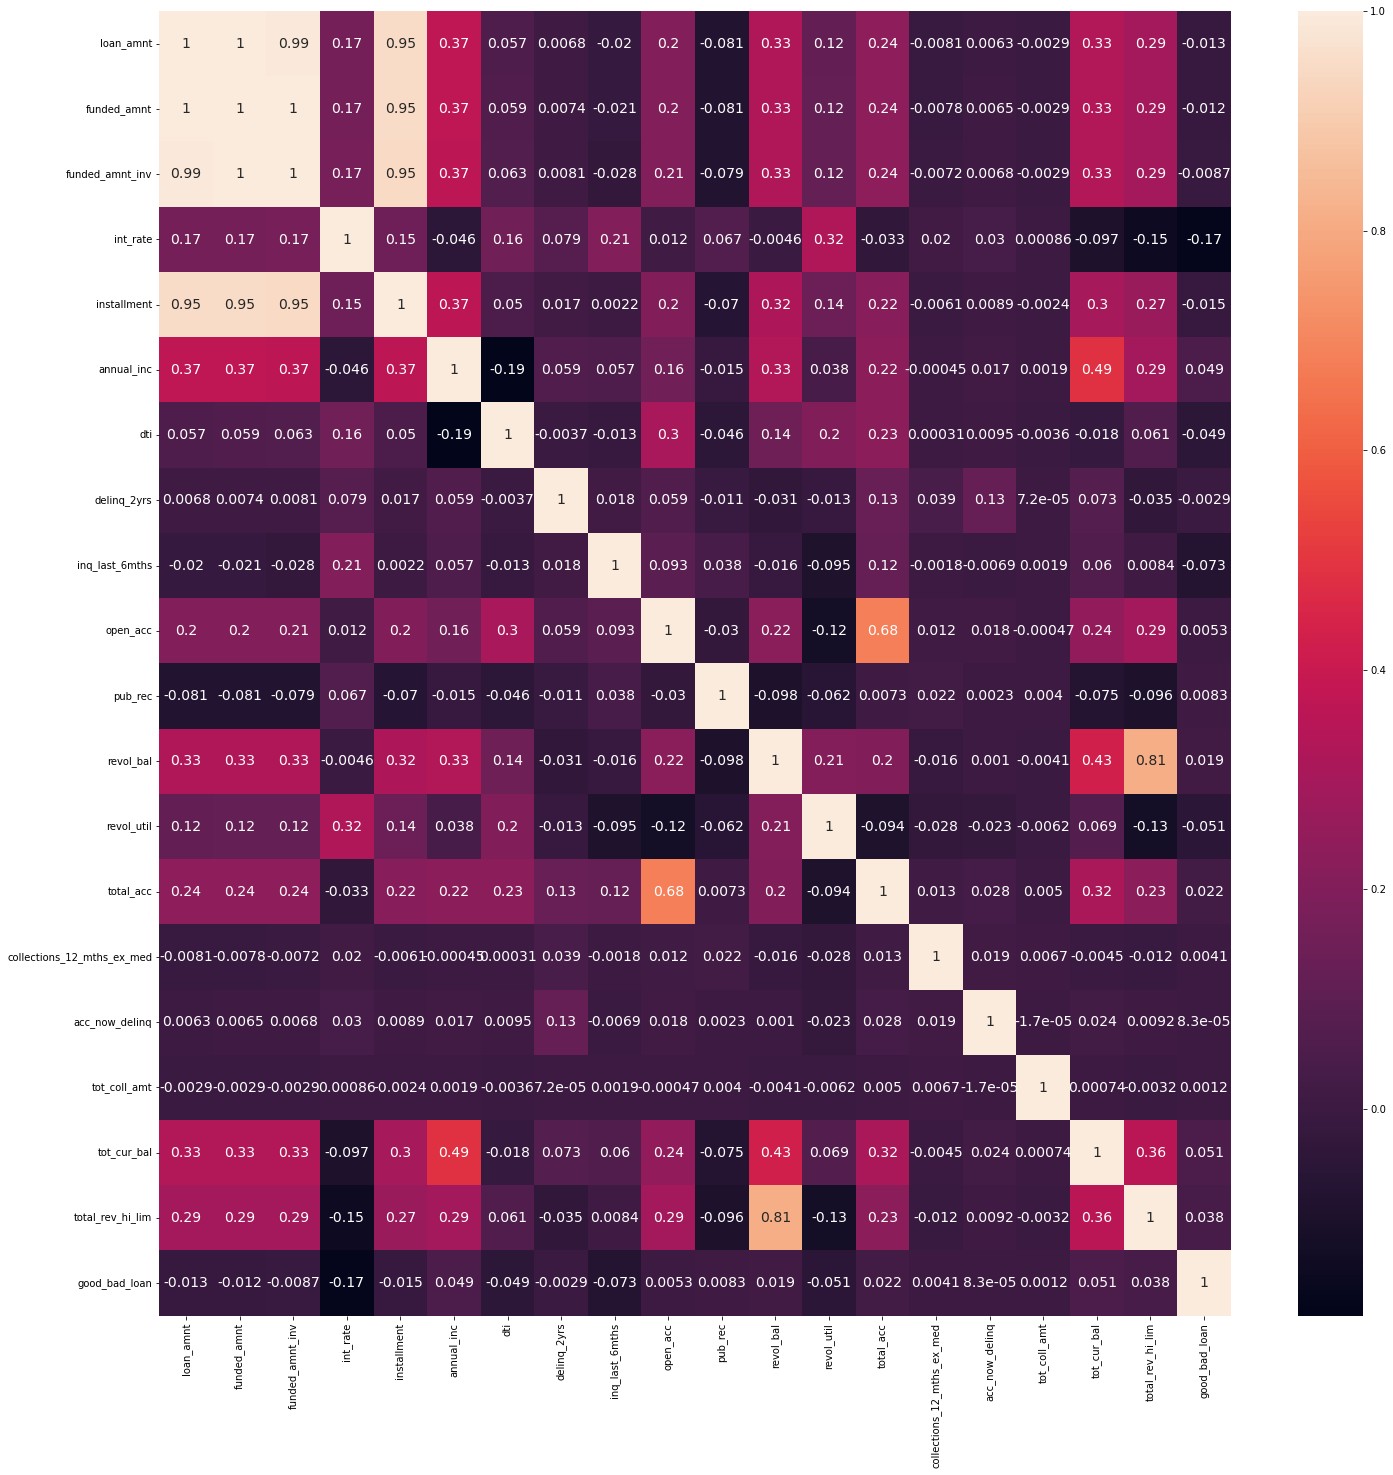

In [13]:
#Check correlation
plt.figure(figsize=(24,24))
sns.heatmap(loan_data.corr(), annot=True, annot_kws={'size':14})

**Catatan** : loan_amnt, funded_amnt, funded_amnt_inv mempunyai nilai korelasi yang hampir sama dengan kolom lain. Jadi mungkin memiliki data yang bersifat duplikat.

In [14]:
# Check the suspect similar columns
loan_data[['loan_amnt','funded_amnt','funded_amnt_inv']].describe()

,loan_amnt,funded_amnt,funded_amnt_inv
count,466285.000000,466285.000000,466285.000000
mean,14317.277577,14291.801044,14222.329888
std,8286.509164,8274.371300,8297.637788
min,500.000000,500.000000,0.000000
25%,8000.000000,8000.000000,8000.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,19950.000000
max,35000.000000,35000.000000,35000.000000


Berdasarkan data diatas, dapat disimpulkan bahwa ketiga fitur tersebut memiliki data yang hampir sama, jadi kita bisa menghapus dua fiturnya.

In [15]:
loan_data.drop(columns = ['funded_amnt', 'funded_amnt_inv'], inplace = True)

### Checking missing value

In [16]:
loan_data.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
purpose                           0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                         29
pub_rec                          29
revol_bal                         0
revol_util                      340
total_acc                        29
initial_list_status               0
last_credit_pull_d               42
collections_12_mths_ex_med      145
acc_now_delinq                   29
tot_coll_amt                  70276
tot_cur_bal                   70276
total_rev_hi_lim              70276
good_bad_loan               

In [17]:
# retriving the columns which has any null values
loan_data_columns=loan_data.columns[loan_data.isnull().any()].tolist()
loan_data[loan_data_columns].isnull().sum()*100/len(loan_data)

emp_length                     4.505399
annual_inc                     0.000858
delinq_2yrs                    0.006219
earliest_cr_line               0.006219
inq_last_6mths                 0.006219
open_acc                       0.006219
pub_rec                        0.006219
revol_util                     0.072917
total_acc                      0.006219
last_credit_pull_d             0.009007
collections_12_mths_ex_med     0.031097
acc_now_delinq                 0.006219
tot_coll_amt                  15.071469
tot_cur_bal                   15.071469
total_rev_hi_lim              15.071469
dtype: float64

**Notes: [tot_coll_amt, tot_cur_bal, total_rev_hi_lim]** mempunya nilai total missing sebesar 15%. Jadi ketiga kolom tersebut perlu kita cek terlebih dahulu.
- tot_coll_amt: Jumlah total tagihan yang pernah terhutang
- tot_cur_bal: Total saldo saat ini dari semua akun
- total_rev_hi_lim: Total kredit/batas kredit tinggi bergulir

In [18]:
# Check tot_coll_amt, tot_cur_bal, total_rev_hi_lim
total_cols = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

loan_data[total_cols].head(10)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [19]:
loan_data[total_cols].sample(10)

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
60402,0.0,28379.0,14700.0
228484,NaN,NaN,NaN
49630,0.0,80214.0,40100.0
388636,0.0,246686.0,67600.0
314244,0.0,99562.0,8400.0
52818,0.0,285527.0,92900.0
48688,0.0,9848.0,23700.0
202084,NaN,NaN,NaN
5439,NaN,NaN,NaN
328237,0.0,485051.0,13800.0


In [20]:
loan_data[total_cols].describe()

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,3.960090e+05,3.960090e+05,3.960090e+05
mean,1.919135e+02,1.388017e+05,3.037909e+04
std,1.463021e+04,1.521147e+05,3.724713e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.861800e+04,1.350000e+04
50%,0.000000e+00,8.153900e+04,2.280000e+04
75%,0.000000e+00,2.089530e+05,3.790000e+04
max,9.152545e+06,8.000078e+06,9.999999e+06


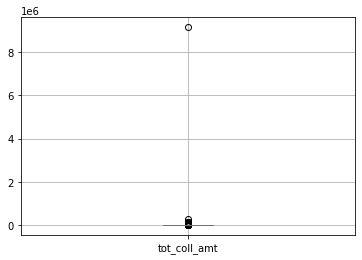

In [21]:
loan_data.boxplot(column=['tot_coll_amt'])
plt.show()

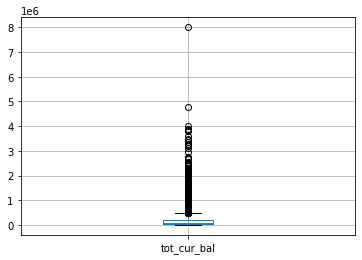

In [22]:
loan_data.boxplot(column=['tot_cur_bal'])
plt.show()

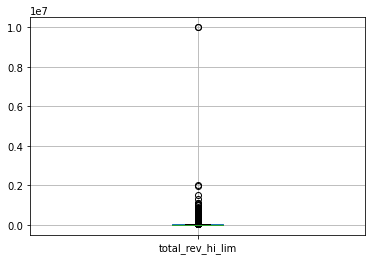

In [23]:
loan_data.boxplot(column=['total_rev_hi_lim'])
plt.show()

Kesimpulan:
- 75% data dari kolom tot_coll_amt adalah 0.
- Data untuk setiap baris sangat berbeda sehingga tidak mungkin mengisi nilai yang hilang dengan nilai rata-rata atau nilai lainnya..
- total missing value 70276 = 15.07% dari seluruh data.
- Baris dari nilai yang hilang di kolom tersebut akan dihapus.

In [24]:
# Menghapus nilai missing value
loan_data.dropna(subset = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'], inplace = True)
loan_data.reset_index(drop= True, inplace = True)

### Pre-processing Beberapa variabel kontinyu (Data Type Transformation)
Variabel berikut tidak memiliki tipe data yang sesuai dan harus dimodifikasi.

In [25]:
continuous_cols = ['term', 'emp_length', 'earliest_cr_line', 'last_credit_pull_d']
loan_data[continuous_cols]

,term,emp_length,earliest_cr_line,last_credit_pull_d
0,36 months,10+ years,Oct-86,Dec-15
1,36 months,1 year,Jan-07,Jan-16
2,36 months,10+ years,Mar-94,Jan-16
3,36 months,10+ years,Oct-98,Jan-16
4,36 months,2 years,Mar-98,Jan-16
...,...,...,...,...
396004,60 months,4 years,Apr-03,Jan-16
396005,60 months,10+ years,Jun-97,Jan-16
396006,60 months,7 years,Dec-01,Dec-15
396007,36 months,3 years,Feb-03,Apr-15


#### 1. term
term: Jumlah pembayaran pinjaman. Nilai dalam bulan dan dapat berupa 36 atau 60.

In [26]:
# Check the data
loan_data['term']

0          36 months
1          36 months
2          36 months
3          36 months
4          36 months
             ...    
396004     60 months
396005     60 months
396006     60 months
396007     36 months
396008     36 months
Name: term, Length: 396009, dtype: object

In [27]:
# Convert to numerical datatype and replace months with empty strng
loan_data['term'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))
loan_data['term']

0         36
1         36
2         36
3         36
4         36
          ..
396004    60
396005    60
396006    60
396007    36
396008    36
Name: term, Length: 396009, dtype: int64

#### 2. emp_length
Lama waktu bekerja dalam tahun. Nilai yang mungkin adalah antara 0 dan 10 di mana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih.

In [28]:
# Displays unique values of emp_length
loan_data['emp_length'].unique()

array(['10+ years', '1 year', '2 years', '4 years', '3 years', '7 years',
       '5 years', '6 years', '9 years', '8 years', '< 1 year', nan],
      dtype=object)

In [29]:
emp_map = {
    '< 1 year' : '0',
    '1 year' : '1',
    '2 years' : '2',
    '3 years' : '3',
    '4 years' : '4',
    '5 years' : '5',
    '6 years' : '6',
    '7 years' : '7',
    '8 years' : '8',
    '9 years' : '9',
    '10+ years' : '10'
}

loan_data['emp_length'] = loan_data['emp_length'].map(emp_map).fillna('0').astype(int)
loan_data['emp_length'].unique()

array([10,  1,  2,  4,  3,  7,  5,  6,  9,  8,  0])

####  3. earliest_cr_line
 earliest_cr_line: Bulan batas kredit peminjam yang paling awal dilaporkan dibuka

In [30]:
# # Displays a column
loan_data['earliest_cr_line']

0         Oct-86
1         Jan-07
2         Mar-94
3         Oct-98
4         Mar-98
           ...  
396004    Apr-03
396005    Jun-97
396006    Dec-01
396007    Feb-03
396008    Feb-00
Name: earliest_cr_line, Length: 396009, dtype: object

In [31]:
# Extracts the date and the time from a string variable that is in a given format
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [32]:
# Asusmsi kan kita berada di bulan Desember 2017
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
# hitung selisih antara dua tanggal dalam bulan, ubah menjadi tipe data numerik dan bulatkan, setelah itu simpan dalam variabel baru.

In [33]:
# Tunjukan sedikit statistika deskriptif dari kolom ini
loan_data['mths_since_earliest_cr_line'].describe()

count    396009.000000
mean        238.898512
std          95.101534
min        -612.000000
25%         182.000000
50%         224.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [34]:
# Menampilkan baris yang memiliki nilai negatif
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
628,Oct-68,2068-10-01,-610.0
843,Aug-67,2067-08-01,-596.0
1021,Jul-67,2067-07-01,-595.0
1740,Apr-68,2068-04-01,-604.0
3645,Jan-61,2061-01-01,-517.0
...,...,...,...
393727,Jan-68,2068-01-01,-601.0
393984,Jul-66,2066-07-01,-583.0
394824,Oct-67,2067-10-01,-598.0
395224,Sep-67,2067-09-01,-597.0


**Catatan:** Tanggal dari tahun 1969 dan sebelumnya tidak dapat dikonversi dengan benar dan mempunyai nilai negatif yang berbeda.

In [35]:
# Mengubah dtype menjadi string dan mengubah tahun 2069 menjadi 1969 dan seterusnya
loan_data['earliest_cr_line_date'] = loan_data['earliest_cr_line_date'].astype(str)
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0].str.replace('20','19')

C:\Users\yusuf arico\AppData\Local\Temp\ipykernel_8964\1783348318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0].str.replace('20','19')


In [36]:
# Pengecekan terhadap salah satu data contohnya dari 2068 menjadi 1968
loan_data['earliest_cr_line_date'][628]

'1968-10-01'

In [37]:
# Mengubah dtype menjadi datetime lagi
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line_date'])
loan_data['earliest_cr_line_date']

0        1986-10-01
1        2007-01-01
2        1994-03-01
3        1998-10-01
4        1998-03-01
            ...    
396004   2003-04-01
396005   1997-06-01
396006   2001-12-01
396007   2003-02-01
396008   2000-02-01
Name: earliest_cr_line_date, Length: 396009, dtype: datetime64[ns]

In [38]:
# Pengecekan kembali data untuk melihat perubahaanya (asumsi kan pada bulan desember 2015)
loan_data['mths_since_earliest_cr_line_date'] = round(pd.to_numeric((pd.to_datetime('2015-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
# Menampilkan statistik deskriptif dari kolom ini
loan_data['mths_since_earliest_cr_line_date'].describe()

count    396009.000000
mean        218.040865
std          87.849670
min          49.000000
25%         159.000000
50%         201.000000
75%         262.000000
max         863.000000
Name: mths_since_earliest_cr_line_date, dtype: float64

**Catatan**: Sudah tidak ada nilai negatif lagi dan data sudah dikonversi dengan benar.

In [39]:
# drop column earliest_cr_line_date, mths_since_earliest_cr_line, and earliest_cr_line sebagaimana kita tidak membutuhkan data nya lagi.
loan_data.drop(columns = ['earliest_cr_line_date' ,'mths_since_earliest_cr_line', 
                          'earliest_cr_line'], inplace = True)

#### 4. last_credit_pull_d
kapan hari terakhir LC menge'check' credit history

In [40]:
loan_data['last_credit_pull_d']

0         Dec-15
1         Jan-16
2         Jan-16
3         Jan-16
4         Jan-16
           ...  
396004    Jan-16
396005    Jan-16
396006    Dec-15
396007    Apr-15
396008    Jan-16
Name: last_credit_pull_d, Length: 396009, dtype: object

In [41]:
# Asusmsikan sekarang adalah bulan Desember 2017
# Ekstrak tanggal dan waktu dari variabel string yang ada dalam format tertentu. dan isi data NaN dengan max date
loan_data['last_credit_pull_d'] = pd.to_datetime(loan_data['last_credit_pull_d'], format = '%b-%y').fillna(pd.to_datetime("2016-01-01"))

# hitung selisih antara dua tanggal dalam bulan, ubah menjadi tipe data numerik dan bulatkan.
loan_data['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['last_credit_pull_d']) / np.timedelta64(1, 'M')))

# Menampilkan beberapa statistik deskriptif untuk nilai kolom.
loan_data['mths_since_last_credit_pull_d'].describe()

count    396009.000000
mean         25.105753
std           5.213815
min          23.000000
25%          23.000000
50%          23.000000
75%          23.000000
max          64.000000
Name: mths_since_last_credit_pull_d, dtype: float64

**Catatan**: Sudah tidak ada nilai negatif lagi dan data sudah dikonversi dengan benar.

In [42]:
#drop column last_credit_pull_d sebagaimana kita tidak membutuhkan data nya lagi.
loan_data.drop(columns = ['last_credit_pull_d'], inplace = True)

### Checking for missing value (again)

In [43]:
#Checking for missing values
loan_data.isnull().sum()

loan_amnt                             0
term                                  0
int_rate                              0
installment                           0
grade                                 0
emp_length                            0
home_ownership                        0
annual_inc                            0
verification_status                   0
purpose                               0
addr_state                            0
dti                                   0
delinq_2yrs                           0
inq_last_6mths                        0
open_acc                              0
pub_rec                               0
revol_bal                             0
revol_util                          219
total_acc                             0
initial_list_status                   0
collections_12_mths_ex_med            0
acc_now_delinq                        0
tot_coll_amt                          0
tot_cur_bal                           0
total_rev_hi_lim                      0


In [44]:
# drop all rows that contain a lot of missing value
loan_data.dropna(subset = ['revol_util'], inplace = True)

#reset index
loan_data.reset_index(drop= True, inplace = True)

**Catatan**: Sudah tidak ada missing value di semua kolom.

### Explore Data

In [45]:
def risk_percentage(x):
    ratio = (loan_data.groupby(x)['good_bad_loan'] # group by
         .value_counts(normalize=True) # calculate the ratio
         .mul(100) # multiply by 100 to be percent
         .rename('risky (%)') # rename column as percent
         .reset_index())

    sns.lineplot(data=ratio[ratio['good_bad_loan'] == 0], x=x, y='risky (%)')
    plt.title(x)
    plt.show()

In [46]:
print(loan_data.nunique()[loan_data.nunique() < 12].sort_values().index)

Index(['term', 'initial_list_status', 'good_bad_loan', 'verification_status',
       'home_ownership', 'acc_now_delinq', 'grade', 'inq_last_6mths',
       'collections_12_mths_ex_med', 'emp_length'],
      dtype='object')


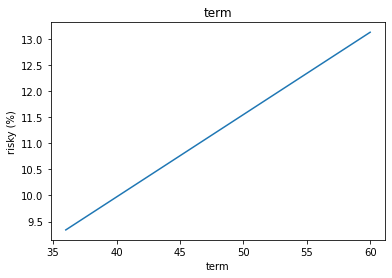

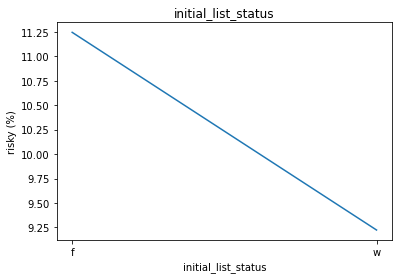

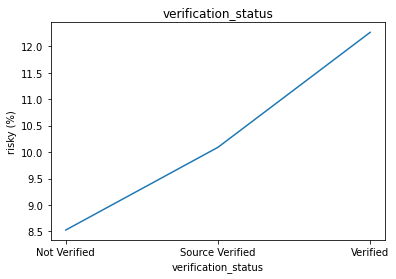

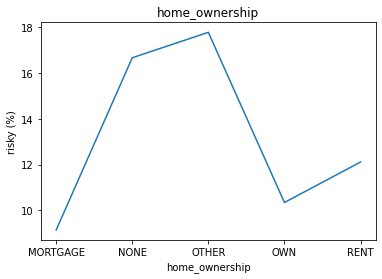

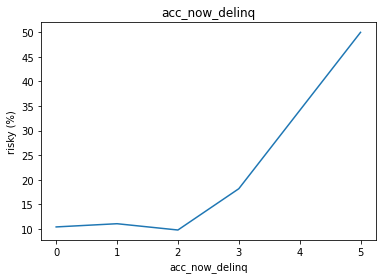

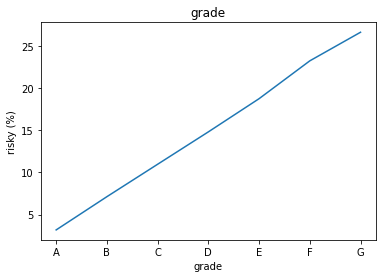

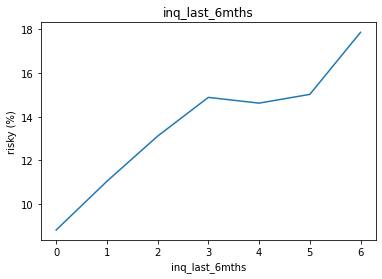

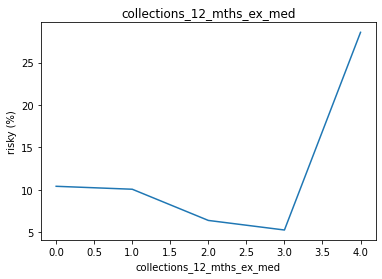

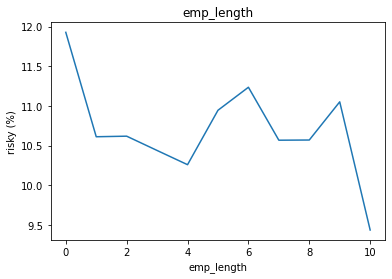

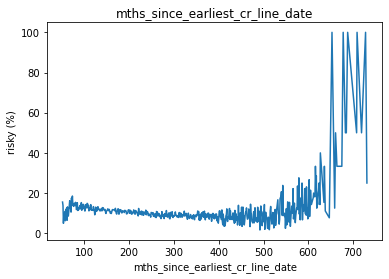

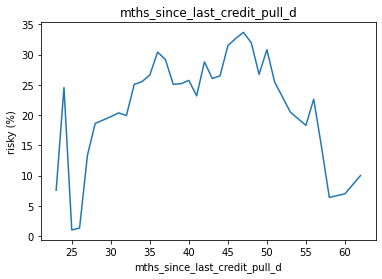

In [47]:
#unique columns and months date column
unq_cols = ['term', 'initial_list_status', 'verification_status',
       'home_ownership', 'acc_now_delinq', 'grade', 'inq_last_6mths',
       'collections_12_mths_ex_med', 'emp_length', 'mths_since_earliest_cr_line_date', 'mths_since_last_credit_pull_d']
for cols in unq_cols:
    risk_percentage(cols)

**Insight**:
- term: memiliki risiko rendah pada term 36 dan risiko tinggi pada term 60.
- initial_list_status: memiliki risiko tinggi pada f dan risiko rendah pada w
- verification_status: memiliki risiko tinggi status diverifikasi
- home_ownership: memiliki risiko tinggi pada jenis kepemilikan None dan Other.
- acc_now_delinq: memiliki risiko rendah 2, 0, 1, dan memiliki nilai risiko tinggi 3, 4, 5
- grade: ada peningkatan risiko yang terkait dengan ini.
- inq_last_6mths: ada peningkatan risiko yang terkait dengan ini.
- collections_12_mths_ex_med: memiliki risiko rendah dengan nilai 3,0 dan memiliki risiko tinggi dengan nilai 4,0
- Employment length: masa kerja kurang dari 1 tahun memiliki persentase risiko terbesar dan masa kerja lebih dari 9 tahun memiliki persentase risiko terkecil.
- Months since earliest cr line date: Semakin awal batas kredit, semakin stabil catatan peminjam, dan ada peningkatan risiko yang terkait dengannya.
- months since last credit pull date: memiliki variasi persentase risiko yang berbeda.

<AxesSubplot:>

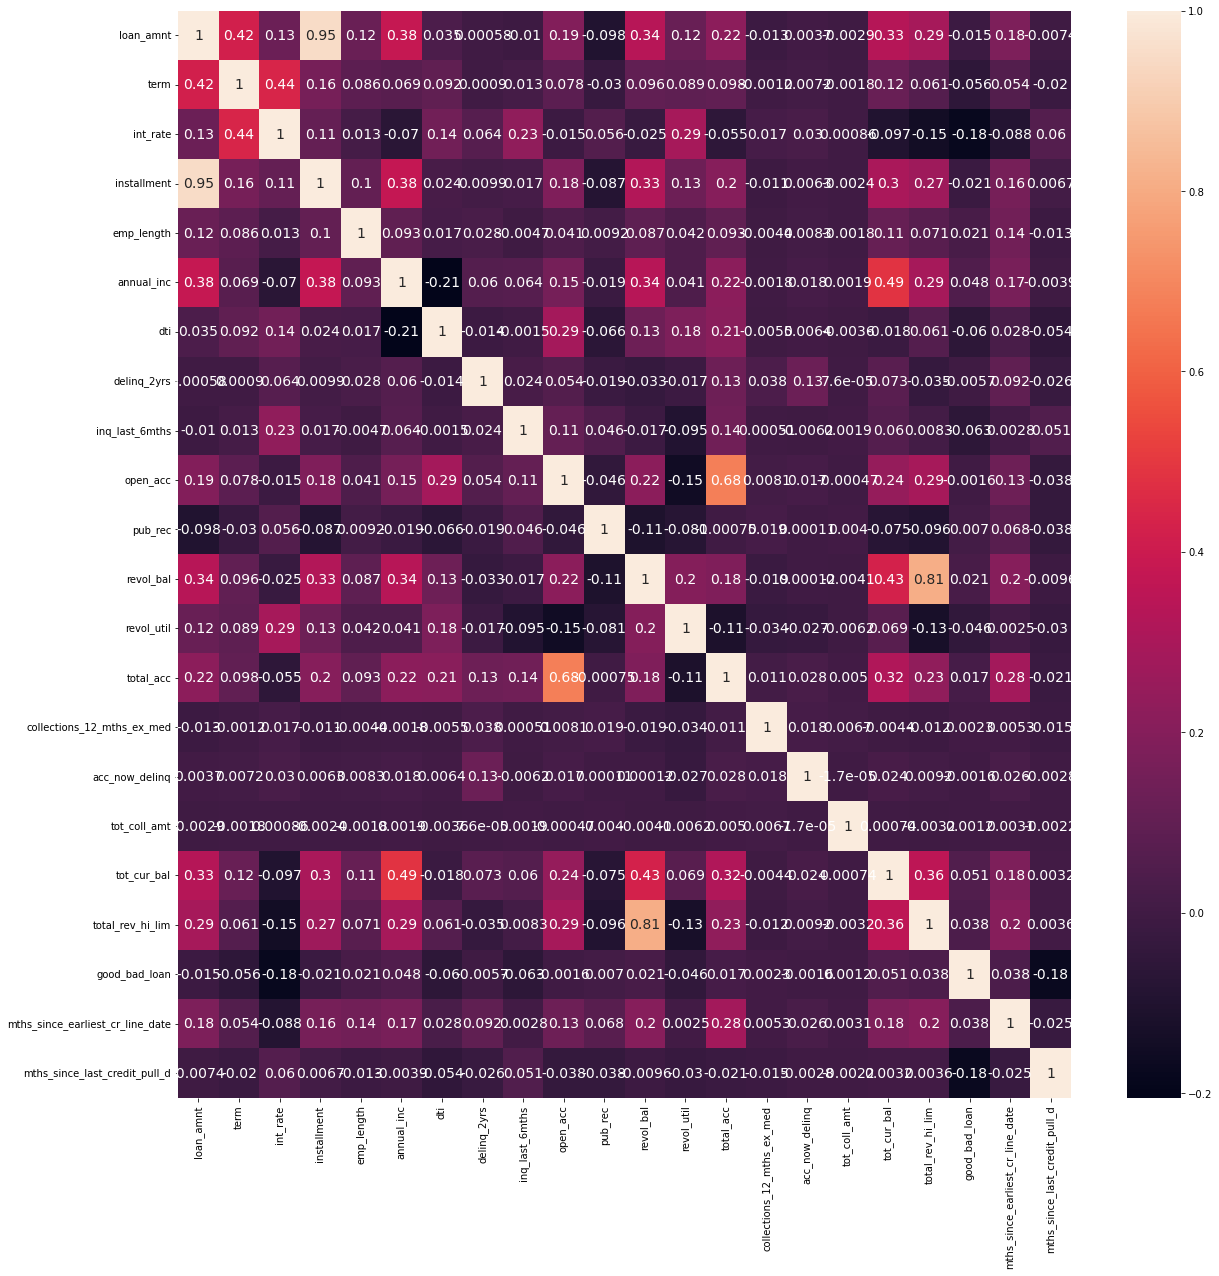

In [48]:
#Check correlation
plt.figure(figsize=(20,20))
sns.heatmap(loan_data.corr(), annot=True, annot_kws={'size':14})

### One Hot Encoding

Mengonversikan kolom kategorikal dengan One Hot Encoding.

In [49]:
# Convert categorical columns with One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
cat_cols = [col for col in loan_data.select_dtypes(include='object').columns.tolist()]
onehot_cols = pd.get_dummies(loan_data[cat_cols], drop_first=True)

In [50]:
onehot_cols

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395785,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
395786,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
395787,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395788,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Standardization

Semua kolom numerik distandarisasi dengan StandardScaler.

In [52]:
from sklearn.preprocessing import StandardScaler

num_cols = [col for col in loan_data.columns.tolist() if col not in cat_cols + ['good_bad_loan']]
ss = StandardScaler()
std_cols = pd.DataFrame(ss.fit_transform(loan_data[num_cols]), columns=num_cols)

In [53]:
std_cols

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line_date,mths_since_last_credit_pull_d
0,1.482304,-0.628484,-0.699079,1.806077,1.103795,-0.348742,0.652418,-0.369343,-0.748128,0.508315,...,0.958852,0.187888,0.126859,-0.090792,-0.063207,-0.013114,-0.157387,0.792444,1.502075,-0.211973
1,-0.600984,-0.628484,-0.016149,-0.459988,-1.286424,-0.879818,0.938065,-0.369343,-0.748128,0.110319,...,-0.411000,-0.178038,0.213154,-0.090792,-0.063207,-0.013114,-0.819722,-0.410481,-1.263790,-0.403817
2,-0.330036,-0.628484,-1.697208,-0.315117,1.103795,0.566906,-0.467318,-0.369343,0.216907,0.110319,...,-0.162505,-1.537192,-0.304615,-0.090792,-0.063207,-0.013114,0.847596,0.824665,0.489063,-0.403817
3,-0.330036,-0.628484,-0.118931,-0.155313,1.103795,-0.623436,-0.100420,-0.369343,-0.748128,-0.884670,...,-0.525429,0.518964,0.558333,-0.090792,-0.063207,1.038259,-0.823129,-0.598438,-0.136956,-0.403817
4,0.031228,-0.628484,-1.176445,0.127371,-1.020844,-0.202238,-0.155011,-0.369343,-0.748128,-0.685672,...,-0.245496,0.754202,0.299449,-0.090792,-0.063207,0.090342,0.879466,-0.402426,-0.057281,-0.403817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395785,0.440660,1.591130,0.095770,-0.051758,-0.489684,0.658471,0.269017,-0.369343,1.181941,1.304307,...,0.317189,0.902315,0.903513,-0.090792,-0.063207,-0.013114,1.027479,-0.013086,-0.751593,-0.403817
395786,0.874177,1.591130,1.351996,0.563089,1.103795,0.072456,0.091281,-0.369343,4.077043,1.304307,...,0.079731,-0.461195,0.385744,-0.090792,-0.063207,-0.013114,0.546283,0.241998,0.045159,-0.403817
395787,0.717629,1.591130,0.671350,0.283442,0.307055,-0.513559,1.005351,-0.369343,1.181941,1.304307,...,-0.472108,-0.252094,1.507577,-0.090792,-0.063207,-0.013114,-0.428579,-0.464183,-0.569478,-0.211973
395788,-1.534248,-0.628484,-1.404850,-1.570003,-0.755264,0.164021,-1.566742,3.227338,0.216907,1.901301,...,-0.246786,-1.541549,0.126859,-0.090792,-0.063207,-0.013114,2.978176,0.609857,-0.728828,1.322778


## Get Final Data

In [54]:
# combining column
final_data = pd.concat([onehot_cols, std_cols, loan_data[['good_bad_loan']]], axis=1)
final_data.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,...,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line_date,mths_since_last_credit_pull_d,good_bad_loan
0,1,0,0,0,0,0,0,0,0,1,...,0.187888,0.126859,-0.090792,-0.063207,-0.013114,-0.157387,0.792444,1.502075,-0.211973,1
1,0,1,0,0,0,0,0,0,0,0,...,-0.178038,0.213154,-0.090792,-0.063207,-0.013114,-0.819722,-0.410481,-1.263790,-0.403817,1
2,0,0,0,0,0,0,1,0,0,0,...,-1.537192,-0.304615,-0.090792,-0.063207,-0.013114,0.847596,0.824665,0.489063,-0.403817,1
3,1,0,0,0,0,0,0,0,0,0,...,0.518964,0.558333,-0.090792,-0.063207,1.038259,-0.823129,-0.598438,-0.136956,-0.403817,1
4,0,0,0,0,0,0,1,0,0,0,...,0.754202,0.299449,-0.090792,-0.063207,0.090342,0.879466,-0.402426,-0.057281,-0.403817,1


## Model Training and Prediction (Main Process)

### Data Splitting

Membuat dataset training dan dataset test, dengan perbandingan 80% untuk data training dan 20% untuk data testing

In [55]:
# separate dependant (y) and independant (X) variable
X = final_data.drop('good_bad_loan', axis = 1)
y = final_data['good_bad_loan']

In [56]:
#spliting data into train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42,stratify=y)

In [57]:
X_train.shape, X_test.shape

((316632, 96), (79158, 96))

### Checking for Class Imbalance in Final Dataset

<AxesSubplot:title={'center':'Good (1) vs Bad (0) Loans Balance'}>

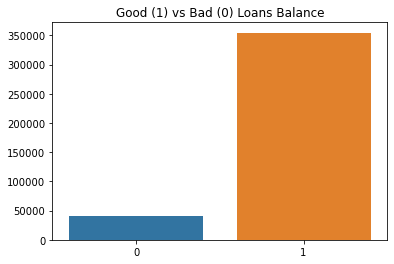

In [58]:
#check if class labels are balanced
plt.title('Good (1) vs Bad (0) Loans Balance')
sns.barplot(x=final_data.good_bad_loan.value_counts().index,y=final_data.good_bad_loan.value_counts().values)

In [59]:
#checking  imbalance for training dataset
y_train.value_counts()

1    283662
0     32970
Name: good_bad_loan, dtype: int64

Dari grafik dan data di atas, data yang tergolong kredit macet memiliki data yang lebih sedikit dibandingkan dengan data kredit bagus. Dengan demikian, dataset ini memiliki data yang **tidak seimbang.**

### Train the model without handling the imbalanced class distribution

In [61]:
# Import Library
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

Melatih model tanpa menangani distribusi kelas yang tidak seimbang menggunakan **Logistic Regression.**

In [62]:
# training
LR= LogisticRegression(max_iter=600).fit(X_train, y_train)
# predicting
y_pred_LR = LR.predict(X_test)

# classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_LR, digits=4, target_names = target_names))

Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.4254    0.0280    0.0526      8242
   good loan     0.8981    0.9956    0.9443     70916

    accuracy                         0.8949     79158
   macro avg     0.6618    0.5118    0.4985     79158
weighted avg     0.8489    0.8949    0.8515     79158



#### Catatan:
Hasil prediksi memiliki hasil yang sangat tidak seimbang antara kelas pinjaman yang buruk dan pinjaman yang baik. dimana untuk kelas kredit macet, hasil recall yang didapatkan mendekati nol. sedangkan pada kelas pinjaman yang baik, nilai recall yang didapat hampir 100%. **Recall** adalah jumlah "positif" yang diprediksi dengan benar dibagi dengan jumlah total "positif". Itu berarti model mengidentifikasi dengan benar 2,80% dari total kredit macet dan mengidentifikasi dengan benar 99,56% dari total kredit bagus.

**Model memperoleh akurasi yang cukup tinggi hanya dengan memprediksi kelas mayoritas, tetapi gagal menangkap kelas minoritas,**

Hal ini mungkin disebabkan oleh dataset yang tidak seimbang sehingga model machine learning mengabaikan kelas minoritas (bad loan class) seluruhnya.

Jadi, ketidakseimbangan kelas ini dapat mempengaruhi model pada pelatihan. Hal ini menjadi ***masalah*** karena diperlukan data kredit macet (kelas minoritas) untuk model prediksi ini

Teknik **OVERSAMPLING** pada kelas minoritas akan digunakan untuk mengatasi ketidakseimbangan data ini.

### Oversampling Minority Class to Resolve Class Imbalance

Random Oversampling melibatkan duplikasi contoh secara acak dari kelas minoritas dan menambahkannya ke dataset pelatihan.

In [64]:
!pip install imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [65]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#check value counts before and after oversampling
print('Before OverSampling:\n{}'.format(y_train.value_counts()))
print('\nAfter OverSampling:\n{}'.format(y_train_ros.value_counts()))

Before OverSampling:
1    283662
0     32970
Name: good_bad_loan, dtype: int64

After OverSampling:
1    283662
0    283662
Name: good_bad_loan, dtype: int64


## Train the model after over sampling

In [67]:
!pip install xgboost

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

### 1. Logistic Regression

In [69]:
# Training 
LR_ros= LogisticRegression(max_iter=600)  
LR_ros.fit(X_train_ros, y_train_ros)

#predicting
y_pred_LR_ros = LR_ros.predict(X_test)

#classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_LR_ros, digits=4, target_names = target_names))


Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.1848    0.6433    0.2871      8242
   good loan     0.9417    0.6701    0.7830     70916

    accuracy                         0.6673     79158
   macro avg     0.5632    0.6567    0.5350     79158
weighted avg     0.8629    0.6673    0.7314     79158



### 2. Random Forest

In [70]:
#building model
rf_ros = RandomForestClassifier(max_depth=10, n_estimators=20)
rf_ros.fit(X_train_ros, y_train_ros)

#predicting
y_pred_rf_ros = rf_ros.predict(X_test)

#classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_rf_ros, digits=4, target_names = target_names))

Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.1848    0.6457    0.2873      8242
   good loan     0.9420    0.6689    0.7823     70916

    accuracy                         0.6665     79158
   macro avg     0.5634    0.6573    0.5348     79158
weighted avg     0.8632    0.6665    0.7308     79158



### 3. Decision Tree

In [71]:
#building model
dt_ros = DecisionTreeClassifier(max_depth = 10)
dt_ros.fit(X_train_ros, y_train_ros)

#predicting
y_pred_dt_ros = dt_ros.predict(X_test)

#classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_dt_ros, digits=4, target_names = target_names))

Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.1942    0.6037    0.2939      8242
   good loan     0.9390    0.7089    0.8079     70916

    accuracy                         0.6980     79158
   macro avg     0.5666    0.6563    0.5509     79158
weighted avg     0.8615    0.6980    0.7544     79158



### 4. XGBOOST

In [73]:
#building model
from xgboost import XGBClassifier
xgb_ros = XGBClassifier(max_depth=5)
xgb_ros.fit(X_train_ros, y_train_ros)

#predicting
y_pred_xgb_ros = xgb_ros.predict(X_test)

#classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_xgb_ros, digits=4, target_names = target_names))

Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.2078    0.6330    0.3129      8242
   good loan     0.9440    0.7196    0.8167     70916

    accuracy                         0.7106     79158
   macro avg     0.5759    0.6763    0.5648     79158
weighted avg     0.8674    0.7106    0.7642     79158



### 5. AdaBoost

In [74]:
#building model
adb_ros = AdaBoostClassifier(n_estimators = 100)
adb_ros.fit(X_train_ros, y_train_ros)

#predicting
y_pred_adb_ros = adb_ros.predict(X_test)

#classification report
target_names = ['bad loan', 'good loan']
print('Classification_Report:')
print(classification_report(y_test, y_pred_adb_ros, digits=4, target_names = target_names))

Classification_Report:
              precision    recall  f1-score   support

    bad loan     0.1951    0.6473    0.2999      8242
   good loan     0.9439    0.6897    0.7970     70916

    accuracy                         0.6853     79158
   macro avg     0.5695    0.6685    0.5485     79158
weighted avg     0.8659    0.6853    0.7453     79158



## Kesimpulan

- Setelah dilakukan model pelatihan dengan data oversampling, diperoleh akurasi tiap kelas (bad loan dan good loan) dengan nilai yang cukup stabil (rata-rata akurasi tiap kelas > 60%). Sehingga dapat dikatakan bahwa penggunaan oversampling dapat membantu model pada saat pelatihan sehingga dapat mendeteksi kelas pinjaman yang buruk dan pinjaman yang baik dengan cukup baik.

- Rata-rata hasil akurasi terbaik diantara semua model di atas adalah menggunakan ***XGBoost Classifier*** dengan rata-rata nilai akurasi sebesar 71,06% (bad loan recall = 63,3% dan good loan recall = 71,96%). Walaupun nilai akurasi ini masih belum tinggi, namun nilai ini sudah cukup tinggi karena dataset yang tidak seimbang. **Recall** adalah jumlah "positif" yang diprediksi dengan benar dibagi dengan jumlah total "positif". Artinya, model ini mengidentifikasi dengan benar 63,3% dari total kredit macet dan mengidentifikasi dengan benar 71,96% dari total kredit bagus.